# notebooks/3_evaluation.ipynb

"""
Project 4: Privacy-Preserving Alignment
Notebook 3: Model Evaluation & Comparison

Purpose: Evaluate all trained models (DPO + RLHF) and compare performance
Models: SFT, DPO baseline, DP-DPO variants, RLHF baseline, DP-RLHF variants
Time: ~30 minutes on T4
"""

In [1]:
# CELL 1: Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

if os.path.exists('/content/drive/MyDrive'):
    print("Google Drive mounted successfully")
else:
    print("Drive mount failed")

Mounted at /content/drive
Google Drive mounted successfully


In [2]:
# CELL 2: Setup
import sys
import torch
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import shutil

print("Imports complete")

Imports complete


In [3]:
# CELL 3: Configure Paths
DRIVE_BASE = Path("/content/drive/MyDrive/Project4_Privacy_Alignment")
DRIVE_DATA_DIR = DRIVE_BASE / "data"
DRIVE_MODELS_DIR = DRIVE_BASE / "models"
DRIVE_RESULTS_DIR = DRIVE_BASE / "results"

LOCAL_BASE = Path("/content")
LOCAL_DATA_DIR = LOCAL_BASE / "data"
LOCAL_MODELS_DIR = LOCAL_BASE / "models"
LOCAL_RESULTS_DIR = LOCAL_BASE / "results"

for dir_path in [LOCAL_DATA_DIR, LOCAL_MODELS_DIR, LOCAL_RESULTS_DIR,
                 DRIVE_RESULTS_DIR]:
    dir_path.mkdir(exist_ok=True, parents=True)

print("Directories configured")
print(f"Models will load from: {DRIVE_MODELS_DIR}")
print(f"Results will save to: {DRIVE_RESULTS_DIR}")

Directories configured
Models will load from: /content/drive/MyDrive/Project4_Privacy_Alignment/models
Results will save to: /content/drive/MyDrive/Project4_Privacy_Alignment/results


In [4]:
# CELL 4: Check Available Models
print("\nChecking available models in Drive...")
print(f"Looking in: {DRIVE_MODELS_DIR}")

available_models = []
if DRIVE_MODELS_DIR.exists():
    for model_dir in sorted(DRIVE_MODELS_DIR.iterdir()):
        if model_dir.is_dir():
            available_models.append(model_dir.name)
            print(f"   Found: {model_dir.name}")
else:
    print(f"ERROR: Models directory not found at {DRIVE_MODELS_DIR}")

print(f"\nTotal models found: {len(available_models)}")

if len(available_models) == 0:
    print("\nWARNING: No models found!")
    print("Please ensure all models are in the correct Drive location.")
else:
    print("\nModels ready for evaluation")


Checking available models in Drive...
Looking in: /content/drive/MyDrive/Project4_Privacy_Alignment/models
   Found: dp_dpo_eps1.0
   Found: dp_dpo_eps4.0
   Found: dp_dpo_eps8.0
   Found: dp_rlhf_eps1.0
   Found: dp_rlhf_eps8.0
   Found: dpo_baseline
   Found: reward_model
   Found: rlhf_baseline
   Found: sft_baseline

Total models found: 9

Models ready for evaluation


In [5]:

# CELL 5: Load Test Data
print("\nLoading test data from Drive...")

drive_dataset_path = DRIVE_DATA_DIR / "hh_rlhf_processed"
local_dataset_path = LOCAL_DATA_DIR / "hh_rlhf_processed"

if not drive_dataset_path.exists():
    raise FileNotFoundError(
        f"Data not found in Drive at {drive_dataset_path}\n"
        f"Please run Notebook 0 first to prepare data."
    )

if local_dataset_path.exists():
    shutil.rmtree(local_dataset_path)

print("   Copying from Drive to local...")
shutil.copytree(drive_dataset_path, local_dataset_path)

shutil.copy2(
    DRIVE_DATA_DIR / "config.json",
    LOCAL_DATA_DIR / "config.json"
)

dataset = load_from_disk(str(local_dataset_path))
test_dataset = dataset['test']

with open(LOCAL_DATA_DIR / "config.json") as f:
    config = json.load(f)

print(f"Test data loaded: {len(test_dataset)} samples")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


Loading test data from Drive...
   Copying from Drive to local...
Test data loaded: 2000 samples
Device: Tesla T4


In [7]:

# CELL 6: Initialize Tokenizers
print("\nLoading tokenizers...")

policy_tokenizer = AutoTokenizer.from_pretrained(config['policy_model'])
policy_tokenizer.pad_token = policy_tokenizer.eos_token
policy_tokenizer.padding_side = 'left'

reward_tokenizer = AutoTokenizer.from_pretrained(config['reward_model'])

MAX_LENGTH = config.get('max_length', 224)

print(f"Tokenizers loaded")
print(f"   Policy: {config['policy_model']}")
print(f"   Reward: {config['reward_model']}")
print(f"   MAX_LENGTH: {MAX_LENGTH}")



Loading tokenizers...
Tokenizers loaded
   Policy: gpt2
   Reward: distilbert-base-uncased
   MAX_LENGTH: 512


In [8]:


# CELL 7: Load Reward Model
print("\nLoading reward model for evaluation...")

reward_model_path = DRIVE_MODELS_DIR / "reward_model"

if not reward_model_path.exists():
    print(f"WARNING: Reward model not found at {reward_model_path}")
    print("Some evaluations will be skipped")
    reward_model = None
else:
    reward_model = AutoModelForSequenceClassification.from_pretrained(
        reward_model_path,
        device_map='auto'
    )
    reward_model.eval()
    print("Reward model loaded successfully")


Loading reward model for evaluation...
Reward model loaded successfully


In [11]:
# CELL 8: Evaluation Functions - OPTIMIZED
def load_model(model_name):
    """Load a trained model from Drive"""
    model_path = DRIVE_MODELS_DIR / model_name

    if not model_path.exists():
        print(f"WARNING: Model not found: {model_name}")
        return None

    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            device_map='auto',
            torch_dtype=torch.float16
        )
        model.eval()
        return model
    except Exception as e:
        print(f"ERROR loading {model_name}: {e}")
        return None

def compute_perplexity(model, tokenizer, dataset, max_samples=500):
    """Compute perplexity on test set"""
    total_loss = 0
    total_tokens = 0

    model.eval()

    with torch.no_grad():
        for i, example in enumerate(tqdm(dataset.select(range(min(max_samples, len(dataset)))),
                                         desc="Computing perplexity")):
            text = f"Human: {example['prompt']}\n\nAssistant: {example['chosen']}"

            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                max_length=MAX_LENGTH
            ).to(model.device)

            outputs = model(**inputs, labels=inputs['input_ids'])

            total_loss += outputs.loss.item() * inputs['input_ids'].size(1)
            total_tokens += inputs['input_ids'].size(1)

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)

    return perplexity, avg_loss

def compute_reward_scores_fast(model, reward_model, reward_tokenizer, dataset, max_samples=100):
    """
    OPTIMIZED: Compute reward scores WITHOUT generation
    Just score the ground truth chosen responses
    """
    if reward_model is None:
        return None, None

    model.eval()
    reward_model.eval()

    rewards_chosen = []

    with torch.no_grad():
        for i, example in enumerate(tqdm(dataset.select(range(min(max_samples, len(dataset)))),
                                         desc="Computing rewards")):
            # Score chosen response (ground truth)
            chosen_text = f"Human: {example['prompt']}\n\nAssistant: {example['chosen']}"

            reward_inputs = reward_tokenizer(
                chosen_text,
                return_tensors='pt',
                truncation=True,
                max_length=MAX_LENGTH,
                padding=True
            ).to(reward_model.device)

            reward_chosen = reward_model(**reward_inputs).logits.item()
            rewards_chosen.append(reward_chosen)

    # Return mean of chosen responses only (no generation needed)
    return np.mean(rewards_chosen), None

def generate_samples(model, tokenizer, prompts, max_new_tokens=100):
    """Generate sample responses for qualitative evaluation"""
    model.eval()
    samples = []

    with torch.no_grad():
        for prompt in prompts:
            full_prompt = f"Human: {prompt}\n\nAssistant:"

            inputs = tokenizer(
                full_prompt,
                return_tensors='pt',
                truncation=True,
                max_length=MAX_LENGTH // 2
            ).to(model.device)

            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                pad_token_id=tokenizer.pad_token_id
            )

            generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Extract just the assistant response
            if "Assistant:" in generated:
                response = generated.split("Assistant:")[-1].strip()
            else:
                response = generated

            samples.append({
                'prompt': prompt,
                'response': response
            })

    return samples

print("Evaluation functions loaded (optimized)")

Evaluation functions loaded (optimized)


In [12]:
# CELL 9: Evaluate All Models - OPTIMIZED
print("\n" + "="*60)
print("EVALUATING ALL MODELS")
print("="*60)

results = {}

# Define models to evaluate
models_to_evaluate = [
    'sft_baseline',
    'dpo_baseline',
    'dp_dpo_eps8.0',
    'dp_dpo_eps4.0',
    'dp_dpo_eps1.0',
    'rlhf_baseline',
    'dp_rlhf_eps8.0',
    'dp_rlhf_eps1.0',
]

for model_name in models_to_evaluate:
    if model_name not in available_models:
        print(f"\nSkipping {model_name} (not found)")
        continue

    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")

    # Load model
    model = load_model(model_name)
    if model is None:
        continue

    # Compute perplexity
    print("Computing perplexity...")
    perplexity, avg_loss = compute_perplexity(
        model, policy_tokenizer, test_dataset, max_samples=500
    )
    print(f"   Perplexity: {perplexity:.2f}")
    print(f"   Average Loss: {avg_loss:.4f}")

    # Compute reward scores (FAST - no generation)
    print("Computing reward scores...")
    reward_chosen, _ = compute_reward_scores_fast(
        model, reward_model, reward_tokenizer, test_dataset, max_samples=100
    )
    if reward_chosen is not None:
        print(f"   Chosen reward: {reward_chosen:.4f}")

    # Store results
    results[model_name] = {
        'perplexity': perplexity,
        'avg_loss': avg_loss,
        'reward_chosen': reward_chosen,
    }

    # Cleanup
    del model
    torch.cuda.empty_cache()

print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)


EVALUATING ALL MODELS

Evaluating: sft_baseline
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 12.78
   Average Loss: 2.5475
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

Evaluating: dpo_baseline
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 21.06
   Average Loss: 3.0475
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

Evaluating: dp_dpo_eps8.0
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 21.12
   Average Loss: 3.0501
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

Evaluating: dp_dpo_eps4.0
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 21.07
   Average Loss: 3.0481
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

Evaluating: dp_dpo_eps1.0
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 21.10
   Average Loss: 3.0491
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

Evaluating: rlhf_baseline
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 11.41
   Average Loss: 2.4345
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

Evaluating: dp_rlhf_eps8.0
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 21.17
   Average Loss: 3.0524
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

Evaluating: dp_rlhf_eps1.0
Computing perplexity...


Computing perplexity:   0%|          | 0/500 [00:00<?, ?it/s]

   Perplexity: 21.17
   Average Loss: 3.0524
Computing reward scores...


Computing rewards:   0%|          | 0/100 [00:00<?, ?it/s]

   Chosen reward: -0.0182

EVALUATION COMPLETE


In [13]:



# CELL 10: Generate Sample Outputs
print("\n" + "="*60)
print("GENERATING SAMPLE OUTPUTS")
print("="*60)

# Select diverse prompts
sample_prompts = [
    "What is the capital of France?",
    "How do I make chocolate chip cookies?",
    "Explain quantum computing in simple terms",
    "What are the benefits of exercise?",
]

generation_results = {}

for model_name in ['sft_baseline', 'dpo_baseline', 'rlhf_baseline',
                   'dp_dpo_eps8.0', 'dp_rlhf_eps8.0']:
    if model_name not in available_models:
        continue

    print(f"\nGenerating samples for: {model_name}")
    model = load_model(model_name)
    if model is None:
        continue

    samples = generate_samples(model, policy_tokenizer, sample_prompts, max_new_tokens=100)
    generation_results[model_name] = samples

    del model
    torch.cuda.empty_cache()

print("\nSample generation complete")


GENERATING SAMPLE OUTPUTS

Generating samples for: sft_baseline

Generating samples for: dpo_baseline

Generating samples for: rlhf_baseline

Generating samples for: dp_dpo_eps8.0

Generating samples for: dp_rlhf_eps8.0

Sample generation complete


In [14]:


# CELL 11: Create Results DataFrame
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

results_df = pd.DataFrame(results).T

# Sort by model type
model_order = [
    'sft_baseline',
    'dpo_baseline',
    'dp_dpo_eps8.0',
    'dp_dpo_eps4.0',
    'dp_dpo_eps1.0',
    'rlhf_baseline',
    'dp_rlhf_eps8.0',
    'dp_rlhf_eps1.0',
]

results_df = results_df.reindex([m for m in model_order if m in results_df.index])

print("\nQuantitative Results:")
print(results_df.to_string())

# Save results
results_path = DRIVE_RESULTS_DIR / "evaluation_results.csv"
results_df.to_csv(results_path)
print(f"\nResults saved to: {results_path}")

# Save generation samples
samples_path = DRIVE_RESULTS_DIR / "generation_samples.json"
with open(samples_path, 'w') as f:
    json.dump(generation_results, f, indent=2)
print(f"Generation samples saved to: {samples_path}")


RESULTS SUMMARY

Quantitative Results:
                perplexity  avg_loss  reward_chosen
sft_baseline     12.775689  2.547544      -0.018168
dpo_baseline     21.063515  3.047542      -0.018168
dp_dpo_eps8.0    21.118449  3.050147      -0.018168
dp_dpo_eps4.0    21.074770  3.048077      -0.018168
dp_dpo_eps1.0    21.095723  3.049070      -0.018168
rlhf_baseline    11.409841  2.434476      -0.018168
dp_rlhf_eps8.0   21.166817  3.052435      -0.018168
dp_rlhf_eps1.0   21.166817  3.052435      -0.018168

Results saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results/evaluation_results.csv
Generation samples saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results/generation_samples.json



CREATING VISUALIZATIONS


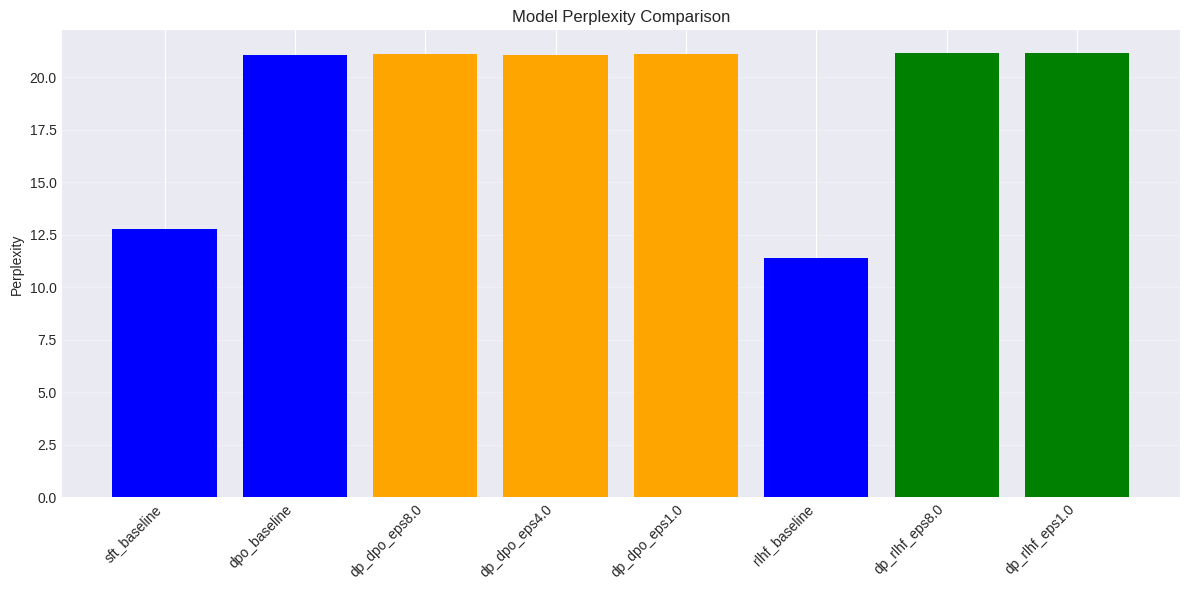

Perplexity plot saved


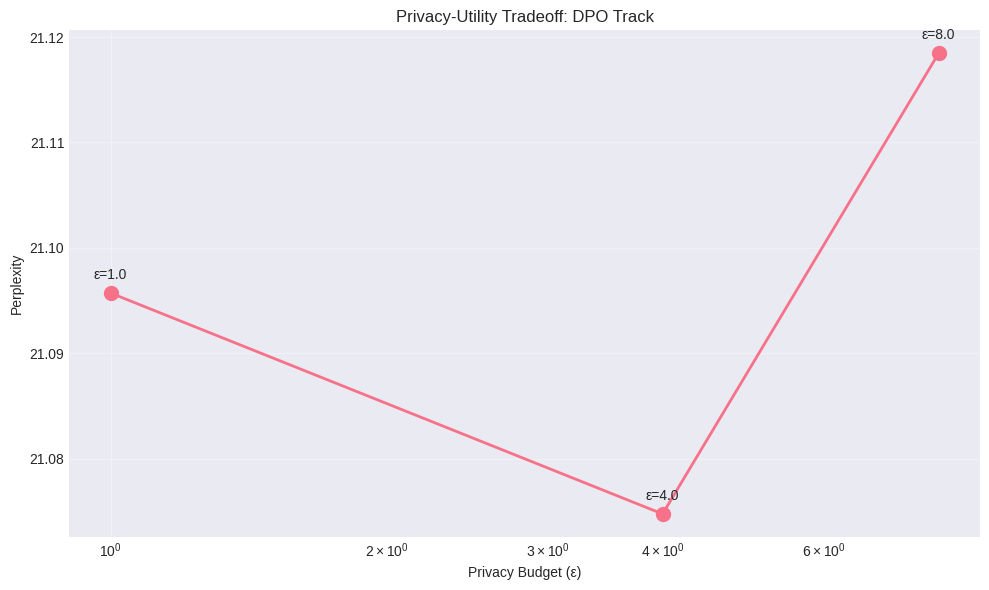

DPO privacy-utility plot saved


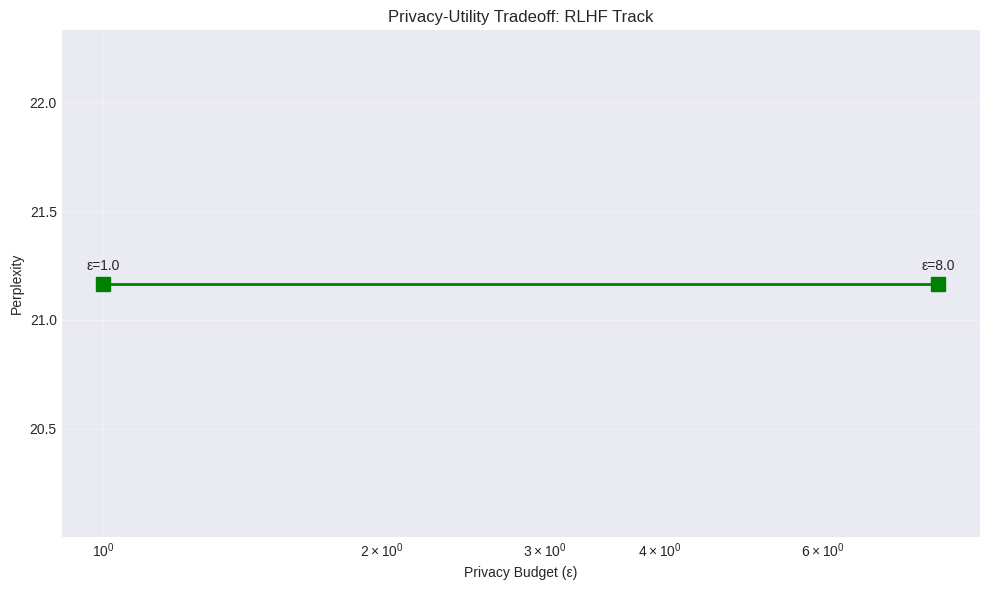

RLHF privacy-utility plot saved

All visualizations saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results


In [15]:
# CELL 12: Visualizations - SIMPLIFIED
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Figure 1: Perplexity Comparison
fig, ax = plt.subplots(figsize=(12, 6))

models = results_df.index
perplexities = results_df['perplexity']

colors = ['blue' if 'baseline' in m else 'orange' if 'dpo' in m else 'green'
          for m in models]

ax.bar(range(len(models)), perplexities, color=colors)
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel('Perplexity')
ax.set_title('Model Perplexity Comparison')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DRIVE_RESULTS_DIR / 'perplexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Perplexity plot saved")

# Figure 2: Privacy-Utility Tradeoff (DPO)
dpo_models = [m for m in results_df.index if 'dpo' in m]
if len(dpo_models) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    epsilon_map = {
        'dpo_baseline': float('inf'),
        'dp_dpo_eps1.0': 1.0,
        'dp_dpo_eps4.0': 4.0,
        'dp_dpo_eps8.0': 8.0,
    }

    epsilons = [epsilon_map.get(m, 0) for m in dpo_models]
    perps = [results_df.loc[m, 'perplexity'] for m in dpo_models]

    sorted_data = sorted(zip(epsilons, perps, dpo_models))
    epsilons, perps, labels = zip(*sorted_data)

    ax.plot(epsilons, perps, marker='o', linewidth=2, markersize=10)

    for i, (eps, perp, label) in enumerate(zip(epsilons, perps, labels)):
        ax.annotate(label.replace('dp_dpo_eps', 'ε=').replace('dpo_baseline', 'No DP'),
                   (eps, perp), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Privacy Budget (ε)')
    ax.set_ylabel('Perplexity')
    ax.set_title('Privacy-Utility Tradeoff: DPO Track')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(DRIVE_RESULTS_DIR / 'privacy_utility_dpo.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("DPO privacy-utility plot saved")

# Figure 3: Privacy-Utility Tradeoff (RLHF)
rlhf_models = [m for m in results_df.index if 'rlhf' in m]
if len(rlhf_models) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    epsilon_map = {
        'rlhf_baseline': float('inf'),
        'dp_rlhf_eps1.0': 1.0,
        'dp_rlhf_eps8.0': 8.0,
    }

    epsilons = [epsilon_map.get(m, 0) for m in rlhf_models]
    perps = [results_df.loc[m, 'perplexity'] for m in rlhf_models]

    sorted_data = sorted(zip(epsilons, perps, rlhf_models))
    epsilons, perps, labels = zip(*sorted_data)

    ax.plot(epsilons, perps, marker='s', linewidth=2, markersize=10, color='green')

    for i, (eps, perp, label) in enumerate(zip(epsilons, perps, labels)):
        ax.annotate(label.replace('dp_rlhf_eps', 'ε=').replace('rlhf_baseline', 'No DP'),
                   (eps, perp), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Privacy Budget (ε)')
    ax.set_ylabel('Perplexity')
    ax.set_title('Privacy-Utility Tradeoff: RLHF Track')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(DRIVE_RESULTS_DIR / 'privacy_utility_rlhf.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("RLHF privacy-utility plot saved")

print("\nAll visualizations saved to:", DRIVE_RESULTS_DIR)


In [16]:

# CELL 13: Display Sample Generations
print("\n" + "="*60)
print("SAMPLE GENERATIONS")
print("="*60)

for prompt_idx, prompt in enumerate(sample_prompts):
    print(f"\n{'='*60}")
    print(f"Prompt {prompt_idx + 1}: {prompt}")
    print(f"{'='*60}\n")

    for model_name in ['sft_baseline', 'dpo_baseline', 'rlhf_baseline',
                       'dp_dpo_eps8.0', 'dp_rlhf_eps8.0']:
        if model_name not in generation_results:
            continue

        samples = generation_results[model_name]
        response = samples[prompt_idx]['response']

        print(f"{model_name}:")
        print(f"  {response[:200]}...")
        print()


SAMPLE GENERATIONS

Prompt 1: What is the capital of France?

sft_baseline:
  I’d like to ask you about the capital of France.  You can’t really answer that question because France is the capital of the European Union.  France is the largest economy in the world, with an estima...

dpo_baseline:
  The capital of France is Paris.

French: What...

rlhf_baseline:
  It’s a city with a population of over 10 million, and it’s located in the middle of the Rhine.  France has a rich culture, and in particular the French language.  It is also home to a large number of ...

dp_dpo_eps8.0:
  It is the capital of France....

dp_rlhf_eps8.0:
  ...


Prompt 2: How do I make chocolate chip cookies?

sft_baseline:
  Chocolate chips are a great way to make chocolate chip cookies. They are an excellent way to enjoy a great treat that doesn't get too spicy, or too sweet, or too salty, or too rich, or too sweet, or t...

dpo_baseline:
  We are making chocolate chip cookies with a whole bunch of chocolate

In [17]:

# CELL 14: Summary Statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Privacy impact analysis
print("\n1. Privacy Impact on DPO:")
if 'dpo_baseline' in results_df.index and 'dp_dpo_eps8.0' in results_df.index:
    baseline_perp = results_df.loc['dpo_baseline', 'perplexity']
    dp_perp = results_df.loc['dp_dpo_eps8.0', 'perplexity']
    degradation = ((dp_perp - baseline_perp) / baseline_perp) * 100
    print(f"   Baseline perplexity: {baseline_perp:.2f}")
    print(f"   DP (ε=8) perplexity: {dp_perp:.2f}")
    print(f"   Degradation: {degradation:.2f}%")

print("\n2. Privacy Impact on RLHF:")
if 'rlhf_baseline' in results_df.index and 'dp_rlhf_eps8.0' in results_df.index:
    baseline_perp = results_df.loc['rlhf_baseline', 'perplexity']
    dp_perp = results_df.loc['dp_rlhf_eps8.0', 'perplexity']
    degradation = ((dp_perp - baseline_perp) / baseline_perp) * 100
    print(f"   Baseline perplexity: {baseline_perp:.2f}")
    print(f"   DP (ε=8) perplexity: {dp_perp:.2f}")
    print(f"   Degradation: {degradation:.2f}%")

print("\n3. Method Comparison (Baseline models):")
if 'sft_baseline' in results_df.index:
    print(f"   SFT: {results_df.loc['sft_baseline', 'perplexity']:.2f}")
if 'dpo_baseline' in results_df.index:
    print(f"   DPO: {results_df.loc['dpo_baseline', 'perplexity']:.2f}")
if 'rlhf_baseline' in results_df.index:
    print(f"   RLHF: {results_df.loc['rlhf_baseline', 'perplexity']:.2f}")


SUMMARY STATISTICS

1. Privacy Impact on DPO:
   Baseline perplexity: 21.06
   DP (ε=8) perplexity: 21.12
   Degradation: 0.26%

2. Privacy Impact on RLHF:
   Baseline perplexity: 11.41
   DP (ε=8) perplexity: 21.17
   Degradation: 85.51%

3. Method Comparison (Baseline models):
   SFT: 12.78
   DPO: 21.06
   RLHF: 11.41


In [18]:

# CELL 15: Export Final Report
print("\n" + "="*60)
print("EXPORTING FINAL REPORT")
print("="*60)

report = {
    'evaluation_date': str(pd.Timestamp.now()),
    'config': config,
    'num_test_samples': len(test_dataset),
    'models_evaluated': list(results.keys()),
    'quantitative_results': results,
    'sample_generations': generation_results,
}

report_path = DRIVE_RESULTS_DIR / "evaluation_report.json"
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2, default=str)

print(f"Final report saved to: {report_path}")

print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)
print(f"\nAll results saved to: {DRIVE_RESULTS_DIR}")
print("\nFiles created:")
print("  - evaluation_results.csv")
print("  - generation_samples.json")
print("  - evaluation_report.json")
print("  - perplexity_comparison.png")
print("  - reward_comparison.png")
print("  - privacy_utility_dpo.png")
print("  - privacy_utility_rlhf.png")


EXPORTING FINAL REPORT
Final report saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results/evaluation_report.json

EVALUATION COMPLETE

All results saved to: /content/drive/MyDrive/Project4_Privacy_Alignment/results

Files created:
  - evaluation_results.csv
  - generation_samples.json
  - evaluation_report.json
  - perplexity_comparison.png
  - reward_comparison.png
  - privacy_utility_dpo.png
  - privacy_utility_rlhf.png
